# To do:
# Notes:
* Team variable tends to be good for every pos except for TE
* Still cant outperform ADP to predict points, and this is troubling, because ADP isnt even linear

# Import packages and define functions

In [1]:
###################### Import Packages #############################################
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import copy
from sklearn.ensemble import RandomForestRegressor
from skgarden import RandomForestQuantileRegressor
from sklearn.model_selection import train_test_split
from ffb_functions import *
import statsmodels.formula.api as smf
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 500)


####################################### Functions ######################################
shifted = pd.read_csv('../database_building/final_frame_teams.csv')
shifted = shifted.replace('NULL', np.nan)
# for undrafted free agents
shifted['Pick'] = shifted['Pick'].replace(0, 256)
################ Seperate database by position ####################################################
pos_dict = {}

for pos in ['TE', 'WR', 'RB', 'QB']:
    pos_dict[pos] = shifted.loc[shifted.FantPos == pos].reset_index(drop = True)
    
    # drop irrelevant variables
    pos_dict[pos] = pos_dict[pos].drop(['TD.3', 'RuTD', 'PaTD', 'ReTD', 'PPR', 'PaAtt', 'RuAtt'
                                        , 'Rec', 'PaYds' , 'ReYds', 'RuYds', 'Int', 'Cmp', 'Tgt'
                                       ,'Rk' , 'FantPos', 'College', 'Old_Team',
                    '2PP', 'delta_ppg', 'ppg_next_year', 'g_next_year', 'OvRank'
                    , 'DKPt', 'FDPt', 'VBD', 'FantPt'], axis = 1)
    if pos != 'QB':
        pos_dict[pos] = pos_dict[pos].drop([ 'PaYds_per_PaAtt', 'PaAtt_per_game'
                                          , 'PaTD_per_PaAtt', 'Cmp_per_PaAtt', 'Int_per_PaAtt'
                                           ], axis = 1)
    else:
        pos_dict[pos] = pos_dict[pos].drop(['Rec_per_tgt', 'ReTD_per_rec'
                                           ,'Tgt_per_game', 'ReYds/R'], axis = 1)

        


/Users/JoshCoven/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [6]:
(pos_dict['RB']
 .loc[pos_dict['RB'].Year == 2018]
 .sort_values('Overall'))#[['Name', 'PPR', 'Overall', 'pts_next_year']]
#len(pos_dict['RB'].columns)

,Name,Age,G,GS,RuY/A,ReYds/R,Fmb,FL,2PM,PosRank,Year,pts_next_year,G_prev_year,G_prev_year_prev_year,ppg_this_year,season_frac_1,season_frac_2,season_frac_3,RuTD_per_Att,Rec_per_tgt,ReTD_per_rec,start_frac,Tgt_per_game,RuAtt_per_game,Fant_Share,Tm,Overall,Tm_change_flag,opp_difference,ru_opp,Pick,height,Wt,Dash,Vertical,Bench,Broad_Jump,Three_Cone,Shuttle,Win_PCT
409,Saquon Barkley,21.0,16.0,16.0,5.01,7.92,0.0,0.0,1.0,2.0,2018.0,244.1,13.421445,13.567422,24.112500,1.0000,0.829184,0.555084,0.042146,0.752066,0.043956,1.000000,7.562500,16.312500,0.273249,NYG,1.45,0.0,11.0,1.0,2.0,72.000000,233.000000,4.400000,41.000000,29.000000,120.009063,6.99012,4.240000,31.2
470,Christian McCaffrey,22.0,16.0,16.0,5.01,8.10,4.0,1.0,0.0,3.0,2018.0,471.2,16.000000,13.567422,24.093750,1.0000,1.000000,0.555084,0.031963,0.862903,0.056075,1.000000,7.750000,13.687500,0.260508,CAR,2.65,0.0,-18.0,-112.0,8.0,71.000000,202.000000,4.480000,37.500000,10.000000,121.000000,6.57000,4.220000,43.8
113,Alvin Kamara,23.0,15.0,13.0,4.55,8.75,1.0,0.0,3.0,4.0,2018.0,248.5,16.000000,13.567422,23.613333,0.9375,0.968750,0.555084,0.072165,0.771429,0.049383,0.866667,7.000000,12.933333,0.218993,NOR,2.81,0.0,-54.0,-2.0,67.0,70.000000,214.000000,4.560000,39.500000,15.000000,131.000000,6.99012,4.250717,81.2
103,Ezekiel Elliott,23.0,15.0,15.0,4.72,7.36,6.0,1.0,0.0,5.0,2018.0,311.7,10.000000,15.000000,21.940000,0.9375,0.781250,0.625000,0.019737,0.810526,0.038961,1.000000,6.333333,20.266667,0.285405,DAL,5.26,0.0,-49.0,-2.0,4.0,72.000000,225.000000,4.470000,32.500000,20.539474,118.000000,6.99012,4.250717,62.5
280,David Johnson,27.0,16.0,16.0,3.64,8.92,3.0,2.0,1.0,10.0,2018.0,141.5,16.000000,16.000000,15.412500,1.0000,1.000000,0.666667,0.027132,0.657895,0.060000,1.000000,4.750000,16.125000,0.268979,ARI,10.28,0.0,-4.0,-97.0,86.0,73.000000,224.000000,4.500000,41.500000,25.000000,127.000000,6.82000,4.270000,18.8
441,James Conner,23.0,13.0,12.0,4.53,9.04,4.0,2.0,2.0,7.0,2018.0,145.5,14.000000,13.567422,21.538462,0.8125,0.843750,0.555084,0.055814,0.774648,0.018182,0.923077,5.461538,16.538462,0.164832,PIT,10.98,0.0,207.0,0.0,105.0,73.000000,233.000000,4.650000,29.000000,20.000000,113.000000,6.99012,4.250717,60.0
465,Todd Gurley,24.0,14.0,14.0,4.89,9.83,1.0,1.0,3.0,1.0,2018.0,219.4,15.000000,16.000000,26.578571,0.8750,0.906250,0.625000,0.066406,0.728395,0.067797,1.000000,5.785714,18.285714,0.227501,LAR,14.84,0.0,0.0,0.0,10.0,73.000000,222.000000,4.520000,34.634393,17.000000,120.009063,6.99012,4.250717,81.2
180,Dalvin Cook,23.0,11.0,10.0,4.62,7.63,2.0,2.0,0.0,31.0,2018.0,292.4,4.000000,13.567422,13.818182,0.6875,0.468750,0.555084,0.015038,0.816327,0.050000,0.909091,4.454545,12.090909,0.106049,MIN,17.18,0.0,26.0,140.0,41.0,70.000000,210.000000,4.490000,30.500000,22.000000,116.000000,7.27000,4.530000,53.3
427,Nick Chubb,23.0,16.0,9.0,5.19,7.45,0.0,0.0,0.0,15.0,2018.0,255.2,13.421445,13.567422,12.156250,1.0000,0.829184,0.555084,0.041667,0.689655,0.100000,0.562500,1.812500,12.000000,0.142158,CLE,17.26,0.0,-62.0,-140.0,35.0,71.000000,227.000000,4.520000,38.500000,29.000000,128.000000,7.09000,4.250000,46.7
11,Joe Mixon,22.0,14.0,13.0,4.93,6.88,0.0,0.0,0.0,9.0,2018.0,225.4,14.000000,13.567422,17.385714,0.8750,0.875000,0.555084,0.033755,0.781818,0.023256,0.928571,3.928571,16.928571,0.191352,CIN,19.54,0.0,0.0,0.0,48.0,70.572127,215.254279,4.520222,34.634393,20.539474,120.009063,6.99012,4.250717,37.5


# Random forest quantile regressor

In [7]:
def one_pos_model(frame, pos, predict_year, sz, max_feats, m_depth, n_est):

    target = copy.deepcopy(frame)

    # team dummy variables. tends to be bad for QBs
    if pos != 'QB':
        dum = pd.get_dummies(target.Tm)
        target = target.drop('Tm', axis = 1)
        target = pd.concat([target, dum], axis=1)
    else:
        target = target.drop('Tm', axis = 1)

    # save these values to evaluate predictions later
    outcomes = (target
                     .loc[target.Year == predict_year]
                     .reset_index(drop = True)
                     [['Name', 'pts_next_year']])

    # set aside data to use for model prediction when the model is done
    predict_dict = (target
                         .loc[target.Year == predict_year]
                         .reset_index(drop = True)\
                         .drop(['Year', 'pts_next_year', 'Name'], axis=1)
                        #[['Overall']] #test to see if only on ADP is better than lin reg
                        ) 

    # make sure new values arent used in the modeling
    # only use 'sz' years of data before prediction year
    target = (target
              .loc[(target.Year < predict_year)
                  & (target.Year > predict_year - sz)]
              .reset_index(drop = True)
              .drop(['Year', 'Name'], axis=1)
             #[['Overall', 'pts_next_year']] # test to see if only ADP is better than lin reg
             ) 

    # separate labels, targets, features
    labels = np.array(target['pts_next_year'])
    target = target.drop(['pts_next_year'], axis = 1)
    features = np.array(target)
    feature_list = list(target.columns)

    # run model 
    rfqr = RandomForestQuantileRegressor(random_state=0
                                         , n_estimators=n_est
                                         , max_depth = m_depth
                                         , max_features= max_feats
                                        )
    rfqr.fit(features, labels)
    score = rfqr.score(predict_dict, outcomes['pts_next_year'])
    print('{} score: {}'.format(pos, score))
    
    # Get numerical feature importances
    importances = list(rfqr.feature_importances_)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances if pair[1] > 0]
    
    ## create output dictionary
    final_dict = copy.deepcopy(predict_dict)
    final_dict['prediction_median'] = rfqr.predict(predict_dict, quantile=50)
    final_dict['prediction_upper'] = rfqr.predict(predict_dict, quantile=75)
    final_dict['prediction_lower'] = rfqr.predict(predict_dict, quantile=25)
    final_dict['Names'] = outcomes['Name']
    final_dict['pts_next_year'] = outcomes['pts_next_year']
    final_dict['ADP_Pos_Rank'] = final_dict['Overall'].rank()
    final_dict['Predicted_Pos_Rank'] = final_dict['prediction_median'].rank(ascending = False)
    final_dict['Actual_Next_Pos_Rank'] = final_dict['pts_next_year'].rank(ascending = False)
    
    return final_dict, score

In [8]:
cross_frame = pd.DataFrame(columns = ['pos','max_features', 'max_depth', 'n_estimators', 'score'])
formula = "pts_next_year ~  prediction_median"

sz =8           ### window size
predict_year = 2018
n_est = 3000
m_dep = 5
max_f = 'auto'
pos = 'RB'

## chose the year one before, ex: want to predict for 2019 season choose 2018, last year of data
final_dict, score = one_pos_model(pos_dict[pos]
                                  , pos
                                  , predict_year
                                  , sz
                                  , max_f, m_dep
                                  , n_est)

RB score: 0.5680219828009834
Variable: Overall              Importance: 0.52
Variable: ppg_this_year        Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: RuY/A                Importance: 0.02
Variable: ReYds/R              Importance: 0.02
Variable: PosRank              Importance: 0.02
Variable: RuTD_per_Att         Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: RuAtt_per_game       Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Bench                Importance: 0.02
Variable: Three_Cone           Importance: 0.02
Variable: FA                   Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: G                    Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: G_prev_year          Importance: 0.01
Variable: G_prev_year_prev_year Importance: 0.01
Variable: season_frac_1        Importance: 0.01
Variable: season_frac_2        Importance: 0.01
Variable: 

In [9]:
output_dict = copy.deepcopy(final_dict)

test1 = (output_dict
 .sort_values('prediction_median', ascending = False)
 [['Names', 'prediction_median','prediction_upper', 'prediction_lower'
   , 'Overall', 'pts_next_year'
  , 'ADP_Pos_Rank', 'Predicted_Pos_Rank', 'Actual_Next_Pos_Rank']]
.reset_index(drop = True))

test1['window'] = test1['prediction_upper'] - test1['prediction_lower']
test1

,Names,prediction_median,prediction_upper,prediction_lower,Overall,pts_next_year,ADP_Pos_Rank,Predicted_Pos_Rank,Actual_Next_Pos_Rank,window
0,Ezekiel Elliott,275.345838,340.904886,198.199997,5.26,311.7,4.0,1.0,3.0,142.704889
1,Todd Gurley,275.337903,361.524744,178.617199,14.84,219.4,7.0,2.0,14.0,182.907544
2,Alvin Kamara,260.857531,351.650573,173.815800,2.81,248.5,3.0,3.0,9.0,177.834773
3,Dalvin Cook,254.797915,331.591979,187.482967,17.18,292.4,8.0,4.0,6.0,144.109012
4,Christian McCaffrey,233.122192,331.266783,177.948248,2.65,471.2,2.0,5.0,1.0,153.318535
5,Leonard Fournette,216.285597,275.862246,169.318760,26.50,259.4,11.0,6.0,7.0,106.543486
6,James Conner,215.208264,317.222298,154.639668,10.98,145.5,6.0,7.0,28.0,162.582630
7,Joe Mixon,203.228719,272.707704,173.565726,19.54,225.4,10.0,8.0,13.0,99.141978
8,Kerryon Johnson,187.350627,247.050606,122.633796,31.84,85.0,13.0,9.0,44.0,124.416810
9,David Johnson,177.989319,276.503809,68.518940,10.28,141.5,5.0,10.0,30.0,207.984869


# Plots

In [10]:
#np.argsort(median)
output_dict['RB']

KeyError: 'RB'

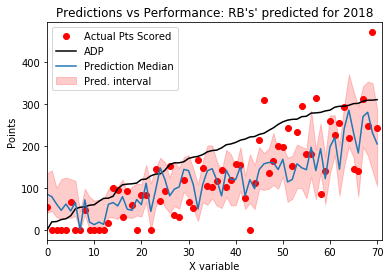

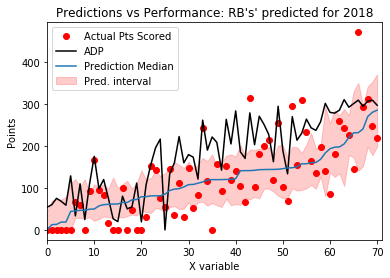

In [70]:
for pos in ['RB'#, 'WR', 'TE', 'QB'
           ]:
    ## view by adp
    adj_adp = output_dict[pos]['Overall']*(-1) + output_dict[pos]['Overall'].max()
    #interval = median
    interval = adj_adp

    sort_ind = np.argsort(interval)
    adp_pos_rank_adp = adj_adp[sort_ind]
    y_true_all_adp = output_dict[pos]['pts_next_year'][sort_ind]
    upper_adp = output_dict[pos].prediction_upper[sort_ind]
    lower_adp = output_dict[pos].prediction_lower[sort_ind]
    median_adp = output_dict[pos].prediction_median[sort_ind]

    plt.plot(np.arange(len(y_true_all_adp)), y_true_all_adp, "ro", label = 'Actual Pts Scored')
    plt.plot(np.arange(len(y_true_all_adp)), adp_pos_rank_adp, "k", label = 'ADP')
    plt.fill_between(
        np.arange(len(upper_adp)), lower_adp, upper_adp, alpha=0.2, color="r",
        label="Pred. interval")
    plt.plot(np.arange(len(y_true_all_adp)), median_adp, label = 'Prediction Median')
    plt.xlabel("X variable")
    plt.ylabel("Points")
    plt.xlim([0, len(upper_adp)])
    plt.legend()
    plt.title("Predictions vs Performance: {}'s' predicted for {}".format(pos, predict_year))
    plt.show()

    ## different view
    interval2 = output_dict[pos].prediction_median
    sort_ind2 = np.argsort(interval2)
    adp_pos_rank_pred = adj_adp[sort_ind2]
    y_true_all_pred = output_dict[pos]['pts_next_year'][sort_ind2]
    upper_pred = output_dict[pos].prediction_upper[sort_ind2]
    lower_pred = output_dict[pos].prediction_lower[sort_ind2]
    median_pred = output_dict[pos].prediction_median[sort_ind2]

    plt.plot(np.arange(len(y_true_all_pred)), y_true_all_pred, "ro", label = 'Actual Pts Scored')
    plt.plot(np.arange(len(y_true_all_pred)), adp_pos_rank_pred, "k", label = 'ADP')
    plt.fill_between(
        np.arange(len(upper_pred)), lower_pred, upper_pred, alpha=0.2, color="r",
        label="Pred. interval")
    plt.plot(np.arange(len(y_true_all_pred)), median_pred, label = 'Prediction Median')
    plt.xlabel("X variable")
    plt.ylabel("Points")
    plt.xlim([0, len(upper_pred)])
    plt.legend()
    plt.title("Predictions vs Performance: {}'s' predicted for {}".format(pos, predict_year))
    plt.show()

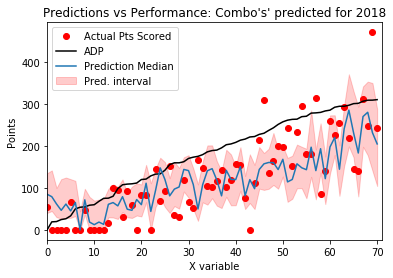

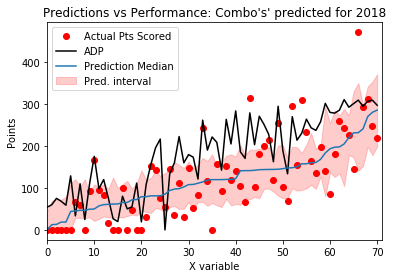

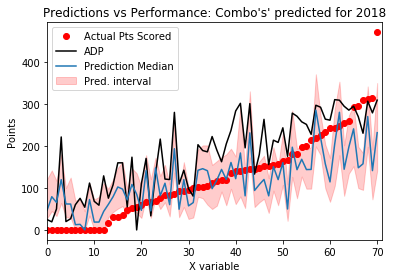

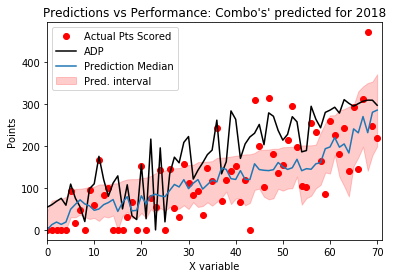

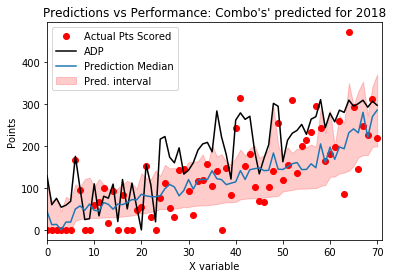

In [71]:
output_dict['Combo'] = (output_dict['RB']
                       #.append(output_dict['WR'])
                       #.append(output_dict['TE'])
                       #.append(output_dict['QB'])
                       .reset_index(drop = True))
for pos in ['Combo'#, 'RB', 'WR', 'TE', 'QB'
           ]:
    ## view by adp
    adj_adp = output_dict[pos]['Overall']*(-1) + output_dict[pos]['Overall'].max()
    #interval = median
    interval = adj_adp

    sort_ind = np.argsort(interval)
    adp_pos_rank_adp = adj_adp[sort_ind]
    y_true_all_adp = output_dict[pos]['pts_next_year'][sort_ind]
    upper_adp = output_dict[pos].prediction_upper[sort_ind]
    lower_adp = output_dict[pos].prediction_lower[sort_ind]
    median_adp = output_dict[pos].prediction_median[sort_ind]

    plt.plot(np.arange(len(y_true_all_adp)), y_true_all_adp, "ro", label = 'Actual Pts Scored')
    plt.plot(np.arange(len(y_true_all_adp)), adp_pos_rank_adp, "k", label = 'ADP')
    plt.fill_between(
        np.arange(len(upper_adp)), lower_adp, upper_adp, alpha=0.2, color="r",
        label="Pred. interval")
    plt.plot(np.arange(len(y_true_all_adp)), median_adp, label = 'Prediction Median')
    plt.xlabel("X variable")
    plt.ylabel("Points")
    plt.xlim([0, len(upper_adp)])
    plt.legend()
    plt.title("Predictions vs Performance: {}'s' predicted for {}".format(pos, predict_year))
    plt.show()

    ## different view
    for order in ['prediction_median', 'pts_next_year', 'prediction_upper', 'prediction_lower']:
        interval2 = output_dict[pos][order]
        sort_ind2 = np.argsort(interval2)
        adp_pos_rank_pred = adj_adp[sort_ind2]
        y_true_all_pred = output_dict[pos]['pts_next_year'][sort_ind2]
        upper_pred = output_dict[pos].prediction_upper[sort_ind2]
        lower_pred = output_dict[pos].prediction_lower[sort_ind2]
        median_pred = output_dict[pos].prediction_median[sort_ind2]

        plt.plot(np.arange(len(y_true_all_pred)), y_true_all_pred, "ro", label = 'Actual Pts Scored')
        plt.plot(np.arange(len(y_true_all_pred)), adp_pos_rank_pred, "k", label = 'ADP')
        plt.fill_between(
            np.arange(len(upper_pred)), lower_pred, upper_pred, alpha=0.2, color="r",
            label="Pred. interval")
        plt.plot(np.arange(len(y_true_all_pred)), median_pred, label = 'Prediction Median')
        plt.xlabel("X variable")
        plt.ylabel("Points")
        plt.xlim([0, len(upper_pred)])
        plt.legend()
        plt.title("Predictions vs Performance: {}'s' predicted for {}".format(pos, predict_year))
        plt.show()
    
    

# Is the model better than ADP?

In [209]:
for pos in ['RB', 'WR', 'QB', 'TE']:
    print(pos)
    formula = "pts_next_year ~  Overall"
    model = smf.ols(formula, output_dict[pos])
    print(model.fit().summary())
    print(model.fit().rsquared)
    print('\n')



RB
                            OLS Regression Results                            
Dep. Variable:          pts_next_year   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     121.0
Date:                Sun, 23 Feb 2020   Prob (F-statistic):           7.86e-17
Time:                        17:06:34   Log-Likelihood:                -391.67
No. Observations:                  71   AIC:                             787.3
Df Residuals:                      69   BIC:                             791.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    240.0145     12.744     18.833      